# Appendix

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
from tqdm import tqdm
from itertools import product
from scipy.stats import sem, t
import multiprocessing as mp
import re
import scipy
import math
import cv2

sys.path.append("./utils")
from myUtils import mkdir
from caAnalysisUtils import RunSimulation, PlotSimulation_CA, GenerateATComparisonPlot_CA, \
                            GenerateATComparisonPlot_ODE, PlotCompetitionOverTime, QQPlot
from odeAnalysisUtils import Simulate_AT_FixedThreshold,rdModel_nsKill,GenerateParameterDic,ProfileTreatmentStrategies
from fittingUtils import LoadPatientData, PlotData, GetBestFit, SimulateFits, PlotFits, SimulateFit

# Format plots
sns.set(style="white",
        font_scale=2.,
        font="Serif",
        rc={'figure.figsize':(12,6)})

In [77]:
### Script parameters
colorDic = {'MTD':'#FF9409','AT50':'#094486'}
runCASimulations = True # Whether to run the CA simulations to generate the data analysed in this script

## Figure A1: Consistency Analysis for Tumours 1-4, with Turnover

Note: data was collected on cluster using the 'collectData_consistencyAnalysis.py' script.

In [78]:
### Parameterise notebook
initialSizeList = [0.25, 0.75]
rFracList = [.001, 0.1]
turnoverList = [0.3]
costList = [0]
nReplicates = 1000
tEnd = 3.65e3
dt = 1.
nSamplesList = [10,50,100,250,500,1000,1500]
nGroupsPerSampleSize = 10
totalSamples = np.sum([x*nGroupsPerSampleSize for x in nSamplesList])
print("Total Number of Samples needed: %d"%totalSamples)

Total Number of Samples needed: 34100


### Load and process data

In [5]:
consistencyAnalysisDf = pd.read_csv("./data/consistencyAnalysis.csv",index_col=0)

In [6]:
consistencyAnalysisDf.head()

,Cost,FinalSize_R_AT,FinalSize_R_CT,InitialTumourSize,MaxNCycles,RFrac,RelTimeGained_CA,ReplicateId,SuppressionDiff_Abs,SuppressionDiff_Sq,TTP_AT50_CA,TTP_CT_CA,Turnover,TumourId,GroupId,NSamples
0,0,3008.0,3023.0,0.25,7.0,0.001,6.500956,0,148.524891,7.704727,1114.0,1046.0,0.3,1,0.0,10.0
1,0,3017.0,3021.0,0.25,9.0,0.001,3.470032,1,168.355667,8.127203,1312.0,1268.0,0.3,1,0.0,10.0
2,0,3008.0,3005.0,0.25,12.0,0.001,14.342895,2,218.778802,9.330116,1714.0,1499.0,0.3,1,0.0,10.0
3,0,3002.0,3014.0,0.25,8.0,0.001,-29.861910,3,172.874864,7.965153,1219.0,1738.0,0.3,1,0.0,10.0
4,0,3021.0,3009.0,0.25,7.0,0.001,7.524752,4,145.016415,7.447031,1086.0,1010.0,0.3,1,0.0,10.0


In [7]:
tmpDicList = []
for tumourId in tqdm(range(1,5)):
    for nSamples in nSamplesList:
        # 1. Compute the KS distance between each group of samples
        ksDistMat = np.ones((nGroupsPerSampleSize,nGroupsPerSampleSize))*np.inf
        for groupId in range(nGroupsPerSampleSize):
            currDataDf = consistencyAnalysisDf.RelTimeGained_CA[(consistencyAnalysisDf.NSamples==nSamples) & 
                                                       (consistencyAnalysisDf.GroupId==groupId) &
                                                       (consistencyAnalysisDf.TumourId==tumourId)]
            nNegative = np.sum(currDataDf<0)
            mean = np.mean(currDataDf)
            nReplicates = currDataDf.shape[0]
            tmpDicList.append({"TumourId":tumourId, "NSamples":nSamples, "GroupId": groupId, 
                               "Prop_NegGain":nNegative/nReplicates*100, "Mean":mean})
distributionStatisticDf = pd.DataFrame(tmpDicList)

100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


### a) Plot the ECDF of the TTP Gained distributions

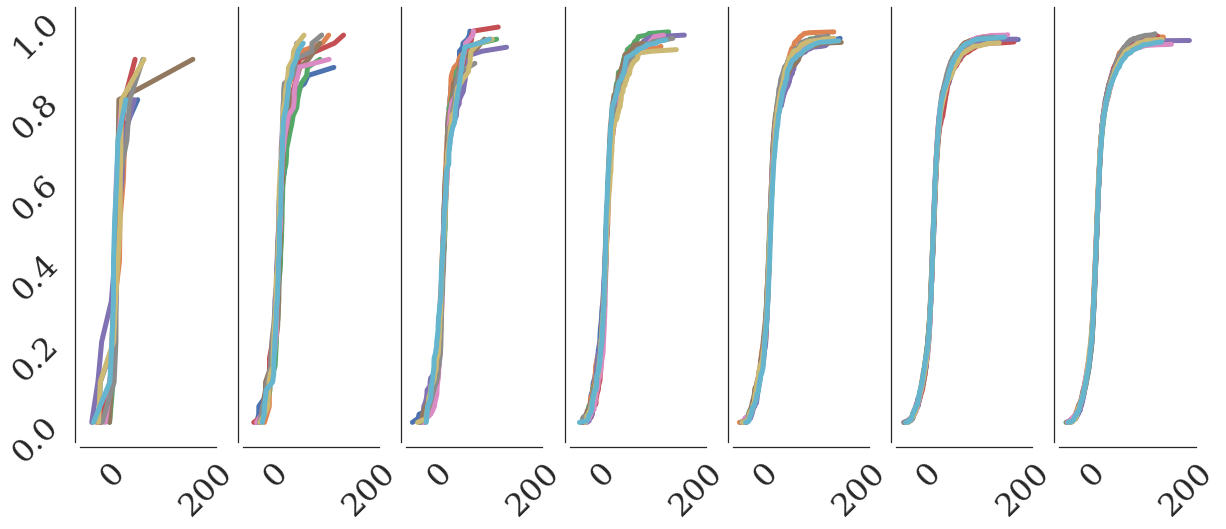

In [9]:
tumourId = 1
fig, axList = plt.subplots(1,len(nSamplesList),sharey=True,sharex=True,figsize=(20,8))

for i,nSamples in enumerate(nSamplesList):
    currAx = axList[i]
    for groupId in range(nGroupsPerSampleSize):
        currDataDf = consistencyAnalysisDf[(consistencyAnalysisDf.NSamples==nSamples) & 
                                  (consistencyAnalysisDf.GroupId==groupId) &
                                  (consistencyAnalysisDf.TumourId==tumourId)]
        currAx.plot(np.sort(currDataDf.RelTimeGained_CA), 
                    np.linspace(0, 1, nSamples, endpoint=False),lw=5)
        currAx.set_ylabel("")
        currAx.tick_params(labelsize=32)
        sns.despine(ax=currAx,offset=5, trim=False)
        currAx.tick_params(rotation=45);
plt.savefig("figures/consistencyExample_Tumour1.pdf")

### b) Plot the mean TTP value as a function of the number of replicates

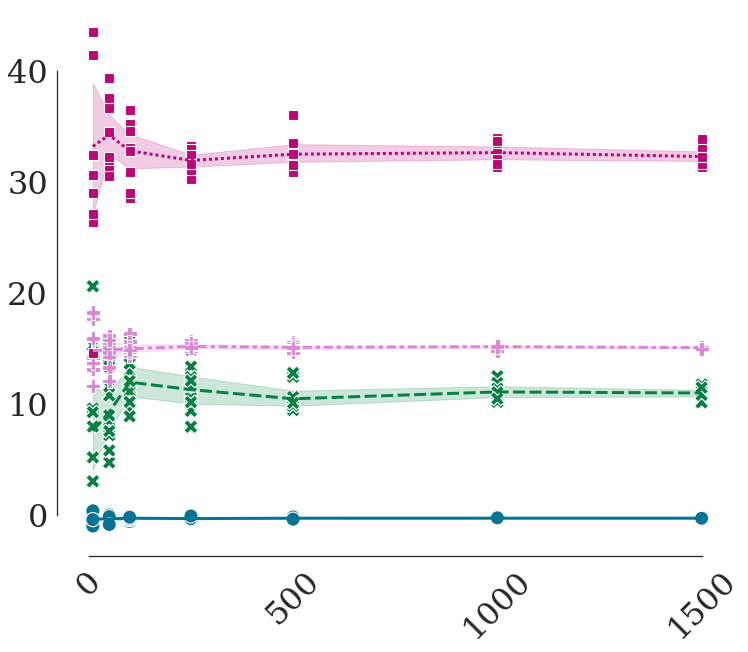

In [10]:
fig, axList = plt.subplots(1,1,figsize=(12,10))
currAx = axList
sns.lineplot(x='NSamples',y='Mean',#err_style='bars',
             style='TumourId',hue='TumourId',
             style_order=[2,1,4,3],
             palette=sns.xkcd_palette(["jungle green", "sea blue", "lavender pink", "magenta"]),
             lw=3,
#             markers=True, lw=3, markersize=5,
             data=distributionStatisticDf,ax=currAx)

sns.scatterplot(x='NSamples',y='Mean',
             style='TumourId',hue='TumourId',
             style_order=[2,1,4,3],
             palette=sns.xkcd_palette(["jungle green", "sea blue", "lavender pink", "magenta"]),
             markers=True, lw=3, s=200,
             data=distributionStatisticDf,ax=currAx)
# currAx.set_xscale('log')
# currAx.set_ylim(-0.05,.5)
currAx.set_xlabel("")
currAx.set_ylabel("")
currAx.tick_params(labelsize=32)
currAx.get_legend().remove()
sns.despine(ax=currAx,offset=5, trim=True)
plt.xticks(rotation=45);
plt.savefig("figures/consistencyAnalysis_meanValue.pdf")

### c) Plot the proportion of runs with AT<CT as a function of the number of replicates

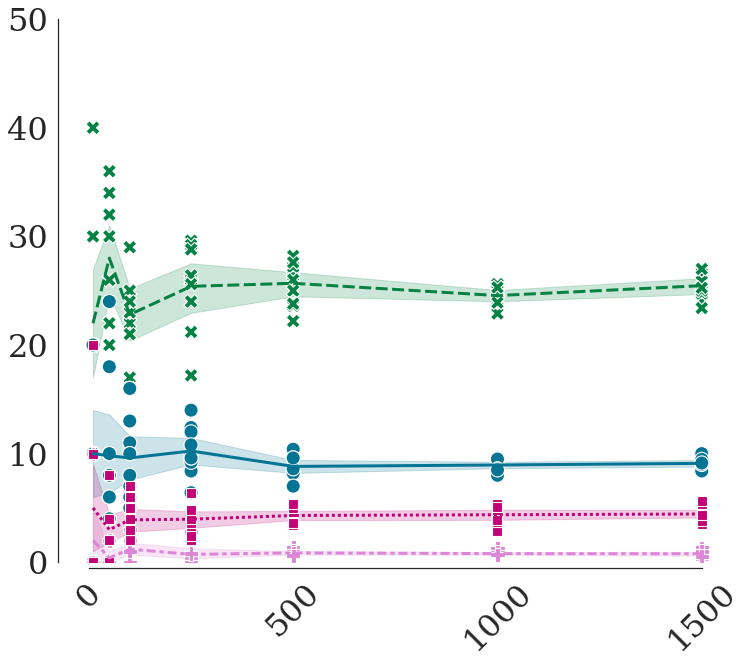

In [11]:
fig, axList = plt.subplots(1,1,figsize=(12,10))
currAx = axList
sns.lineplot(x='NSamples',y='Prop_NegGain',#err_style='bars',
             style='TumourId',hue='TumourId',
             style_order=[2,1,4,3],
             palette=sns.xkcd_palette(["jungle green", "sea blue", "lavender pink", "magenta"]),
             lw=3,
#             markers=True, lw=3, markersize=5,
             data=distributionStatisticDf,ax=currAx)

sns.scatterplot(x='NSamples',y='Prop_NegGain',
             style='TumourId',hue='TumourId',
             style_order=[2,1,4,3],
             palette=sns.xkcd_palette(["jungle green", "sea blue", "lavender pink", "magenta"]),
             markers=True, lw=3, s=200,
             data=distributionStatisticDf,ax=currAx)
# currAx.set_xscale('log')
currAx.set_ylim(-0.05,50)
currAx.set_xlabel("")
currAx.set_ylabel("")
currAx.tick_params(labelsize=32)
currAx.get_legend().remove()
sns.despine(ax=currAx,offset=5, trim=True)
plt.xticks(rotation=45);
plt.savefig("figures/consistencyAnalysis_negGain.pdf")

## Figure A2: Illustrate the possible variability between AT outcomes due to stochasticity

In [16]:
# Params for the figure
initialSize = 0.75
rFrac = 0.001
nReplicates = 250
tEnd = 365*10
seedToShowImagesFor = 0
dataDir = "./data/exampleSims_noCost_noTurnover/data/"
imgDir = "./data/exampleSims_noCost_noTurnover/images/"

In [17]:
tmpList = []
txName = "AT50"
for replicateId in range(nReplicates):
    currDfName = os.path.join(dataDir,"%s_cellCounts_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,rFrac,initialSize,replicateId))
    tmpDf = pd.read_csv(currDfName)
    tmpList.append({"ReplicateId":replicateId,"NCycles":tmpDf.NCycles.max()})
cycleInfoDf = pd.DataFrame(tmpList)

NCycles: 4, NSims: 36
NCycles: 5, NSims: 175
NCycles: 6, NSims: 35
NCycles: 7, NSims: 4


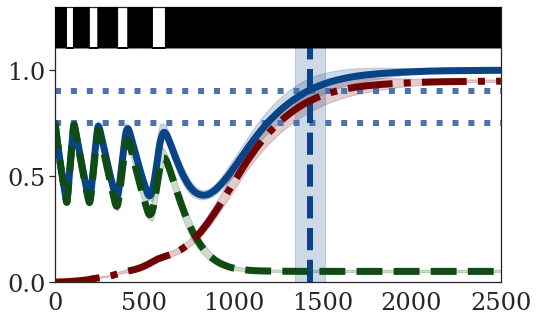

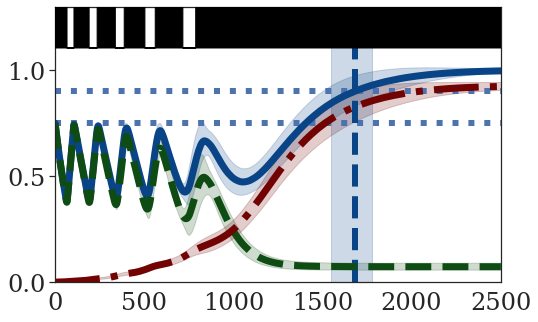

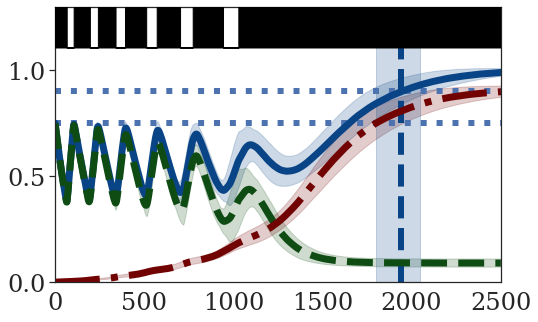

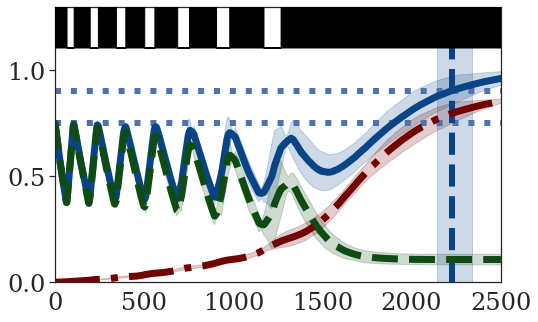

In [21]:
for nCycles in np.sort(cycleInfoDf.NCycles.unique()):
    replicateIdList = cycleInfoDf.ReplicateId[cycleInfoDf.NCycles==nCycles]
    print("NCycles: %d, NSims: %d"%(nCycles,len(replicateIdList)))
    tmpList = []
    for replicateId in replicateIdList:
        currDfName = os.path.join(dataDir,"%s_cellCounts_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,rFrac,initialSize,replicateId))
        tmpDf = pd.read_csv(currDfName)
        tmpDf['NCells'] /= 1e4
        tmpDf['NCells_S'] /= 1e4
        tmpDf['NCells_R'] /= 1e4
        tmpDf['TreatmentBranch'] = txName
        tmpDf['ReplicateId'] = replicateId
        tmpList.append(tmpDf)
    dataDf = pd.concat(tmpList)
    dataDf.rename(columns={"NCells":"V","NCells_S":"S","NCells_R":"R"},inplace=True)
    # Plot
    PlotSimulation_CA(dataDf,xlim=2.5e3,yLimVec=[0,1.3],
                      colorA=[colorDic[txName]],showProgression=True,
                      figsize=(8,5),savefigB=True,outName="figures/exampleSim_nCycles%d.pdf"%nCycles)

In [22]:
cycleInfoDf[cycleInfoDf.ReplicateId==0]

,ReplicateId,NCycles
0,0,5.0


## Figure A3: Effect of changing the AT threshold

In [79]:
atThresholdList = [0.3,0.5]

### Example simulation for n0 = 0.75 and fR = 0.01

In [80]:
# Params for the figure
initialSize = 0.75
rFrac = 0.01
nReplicates = 250
tEnd = 365*10
dataDir = "./data/exampleSims_changingATThreshold/data/"

### Collect Data

In [7]:
# Collect the data for the time series plots showing the treatment dynamics avaraged across nReplicate simulations
if runCASimulations:
    for atThreshold in atThresholdList:
        modelConfigDic = {"initialSize":initialSize,"rFrac":rFrac,"turnover":0,"cost":0,
                          "tEnd":tEnd,"nReplicates":nReplicates,"atThreshold":atThreshold,
                          "profilingMode":"false","terminateAtProgression":"false",
                          "outDir":dataDir}
        RunSimulation(modelConfigDic)

### Plot the simulations

MTD Mean TTP: 457.67
AT30 Mean TTP: 652.19
MTD Mean TTP: 457.67
AT50 Mean TTP: 533.64


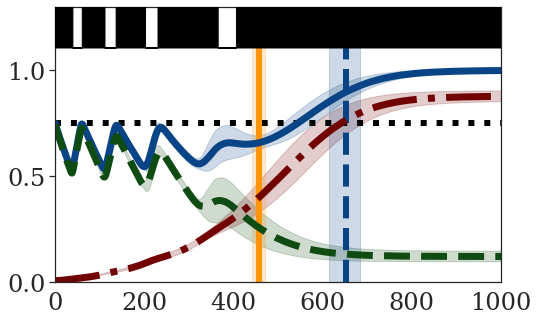

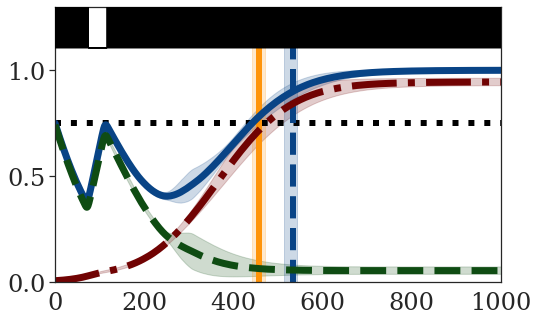

In [11]:
for atThreshold in atThresholdList:
    # Read the data
    tmpList = []
    for replicateId in range(nReplicates):
        for txName in ["MTD","AT%d"%(atThreshold*100)]:
            currDfName = os.path.join(dataDir,"%s_cellCounts_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,rFrac,initialSize,replicateId))
            tmpDf = pd.read_csv(currDfName)
            tmpDf['NCells'] /= 1e4
            tmpDf['NCells_S'] /= 1e4
            tmpDf['NCells_R'] /= 1e4
            tmpDf['TreatmentBranch'] = txName
            tmpDf['ReplicateId'] = replicateId
            tmpList.append(tmpDf)
    dataDf = pd.concat(tmpList)
    dataDf.rename(columns={"NCells":"V","NCells_S":"S","NCells_R":"R"},inplace=True)
    # Plot
    GenerateATComparisonPlot_CA(dataDf,minTime=150,t_end=1e3,ylim=1.3,atName="AT%d"%(100*atThreshold),
                                printTTPB=True,figsize=(8,5),savefigB=True,
                                drugBarPalette={"AT50":"black","AT30":"black"},
                                outName="figures/exampleSim_differentThreshold_thresh%d.pdf"%(atThreshold*100))

In [12]:
timeGained_AT50 = 533.64-457.67
timeGained_AT30 = 652.19-457.67
print("AT50: %1.2f, AT30: %1.2f, Relative Difference: %1.2f"%(timeGained_AT50/30,timeGained_AT30/30,timeGained_AT30/timeGained_AT50))

AT50: 2.53, AT30: 6.48, Relative Difference: 2.56


### Compute difference in TTP

In [34]:
confidence = 0.95
for atThreshold in atThresholdList:
    # Read the data
    tmpList = []
    for i,txName in enumerate(["MTD","AT%d"%(atThreshold*100)]):
        for replicateId in range(nReplicates):
            currDfName = os.path.join(dataDir,"%s_cellCounts_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,rFrac,initialSize,replicateId))
            tmpDf = pd.read_csv(currDfName)
            ttp = tmpDf.Time[(tmpDf.NCells>1.2*tmpDf.NCells.iloc[0]) & 
                     (tmpDf.Time > 150)].min() 
            # The 150 prevents spurious calls of progression which 
            # can sometimes occur early in AT due to very rapid regrowth, 
            # even thought the tumour remains controllable.
            tmpList.append({"TreatmentBranch":txName,"ReplicateId":replicateId,"TTP":ttp})
    ttpDataDf = pd.DataFrame(tmpList)
    
    # Compute difference
    sample_MTD = ttpDataDf.TTP[ttpDataDf.TreatmentBranch=="MTD"].values/30
    sample_AT = ttpDataDf.TTP[ttpDataDf.TreatmentBranch=="AT%d"%(atThreshold*100)].values/30
    m = np.nanmean(sample_AT-sample_MTD)
    std_err = sem(sample_AT-sample_MTD)
    h = std_err * t.ppf((1 + confidence) / 2, nReplicates - 1)
    print("AT Threshold: %d: Mean difference: %1.2f; [%1.2f,%1.2f]"%(atThreshold*100,m,m-h,m+h))
    

AT Threshold: 30: Mean difference: 6.49; [6.34,6.63]
AT Threshold: 50: Mean difference: 2.53; [2.43,2.63]


## Figure A4: Comparison of random and circular initial seeding

### a) Comparison of the relationship between the parameters and TTP between the two initial conditions

In [18]:
rFracPalette = {0.001:sns.xkcd_rgb['coral'],0.01:sns.xkcd_rgb['scarlet'],0.1:sns.xkcd_rgb['dark red']}
sizeDic_n0fR = {0.35:150,0.5:350,0.65:550}

To collect the comparison data run `collectData_circleICs.py`. To get the equivalent runs for random ICs, we can repurpose the data we collected when comparing the ABM and CA model (generated using `collectData_odeComparison.py`).

In [11]:
dataDf_random = pd.read_csv("./data/n0Sweep_odeComparison.csv", index_col=0)
dataDf_circle = pd.read_csv("./data/paramSweep_circleICs_n0fR.csv", index_col=0)

In [12]:
comparisonDf = pd.merge(dataDf_random, dataDf_circle, on=["InitialTumourSize","RFrac","Cost","Turnover","ReplicateId"], suffixes=["_random", "_circle"])

In [13]:
comparisonDf_means = comparisonDf.groupby(by=["InitialTumourSize","RFrac","Cost","Turnover"]).mean()
comparisonDf_means = comparisonDf_means.reset_index()

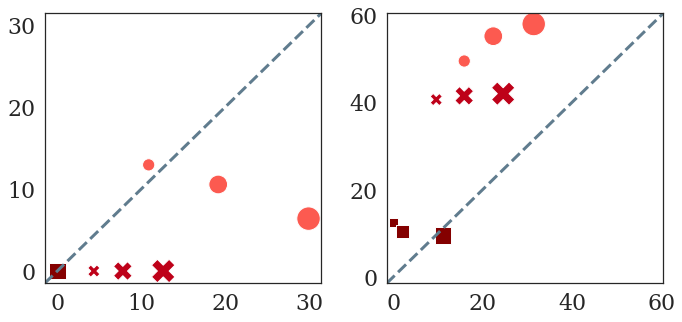

In [19]:
feature = "RelTimeGained_CA"

fig,axList = plt.subplots(1,2,figsize=(10,5))
for i, (cost,turnover) in enumerate(product([0], comparisonDf_means.Turnover.unique())):
    ax = axList.flatten()[i]
    currDataDf = comparisonDf_means[(comparisonDf_means.Cost==cost) & (comparisonDf_means.Turnover==turnover)]
    sns.scatterplot(x="%s_random"%feature, y="%s_circle"%feature,
                    hue="RFrac", style="RFrac", size="InitialTumourSize",
                    palette=rFracPalette, sizes=sizeDic_n0fR, legend=False,
                   data=currDataDf, ax=ax)

    # Set x and y axis to equal scale
    xLimVec = ax.get_xlim()
    yLimVec = ax.get_ylim()
    axLimVec = [min(xLimVec[0],yLimVec[0]),max(xLimVec[1],yLimVec[1])]
    ax.set_xlim(axLimVec)
    ax.set_ylim(axLimVec)
    ax.set_xlabel("")
    ax.set_ylabel("")
#     ax.set_title("(c,d) = (%1.2f,%1.2f)"%(cost,turnover))

    # Plot diagonal line to show where values would be equal
    xVec = np.linspace(*axLimVec,100)
    ax.plot(xVec,xVec,color=sns.xkcd_rgb['blue grey'],lw=3,ls='--')
    plt.tight_layout()
    plt.savefig("./figures/circleVsRandom_n0fR.pdf")    

### b) - d) Example Simulations

In [53]:
tumourList = [[0.75, 0.001, 0., 0.], [0.25, 0.001, 0., 0.], [0.75, 0.001, 0., 0.3]]
nReplicates = 250
tEnd = 365*10
seedToShowImagesFor = 0
dataDir = "./data/exampleSims_circleICs/data/"
imgDir = "./data/exampleSims_circleICs/images/"
solver_kws_circleICs = {'initialSeedingType':'circle_fixedR', "xDim":150, "yDim":150}

#### Collect data

In [54]:
if runCASimulations:
    for i, (initialSize, rFrac, cost, turnover) in enumerate(tqdm(tumourList)):
        # Collect time-series data
        modelConfigDic = {"initialSize":initialSize,"rFrac":rFrac,"turnover":turnover,"cost":cost,
                           **solver_kws_circleICs, "initialSeedingDistance":int(np.sqrt(initialSize*1e4/np.pi)), 
                          'initCellNumber_R': math.ceil(rFrac*initialSize*1e4),
                          "tEnd":tEnd,"nReplicates":nReplicates,
                          "profilingMode":"false","terminateAtProgression":"false",
                          "outDir":os.path.join(dataDir,"tumour_%d/"%i)}
        RunSimulation(modelConfigDic)
        
        # Collect the images for one replicate
        modelConfigDic = {"initialSize":initialSize,"rFrac":rFrac,"turnover":turnover,"cost":cost,
                          **solver_kws_circleICs, "initialSeedingDistance":int(np.sqrt(initialSize*1e4/np.pi)), 
                          'initCellNumber_R': math.ceil(rFrac*initialSize*1e4),
                          "tEnd":tEnd,"seed":seedToShowImagesFor,"nReplicates":1,
                          "profilingMode":"false","terminateAtProgression":"true",
                          "imageOutDir":os.path.join(imgDir,"tumour_%d/"%i),"imageFreq":10,
                          "outDir":"./data/scratch/"}
        RunSimulation(modelConfigDic)

100%|██████████| 3/3 [16:24<00:00, 328.03s/it]


#### Plot time-series plots

MTD Mean TTP: 1251.69
AT50 Mean TTP: 1314.84
MTD Mean TTP: 1021.46
AT50 Mean TTP: 1214.91
MTD Mean TTP: 1527.78
AT50 Mean TTP: 2408.79


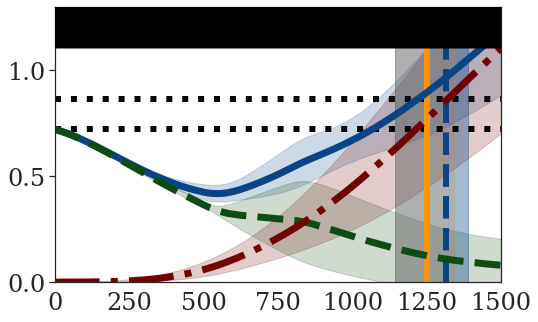

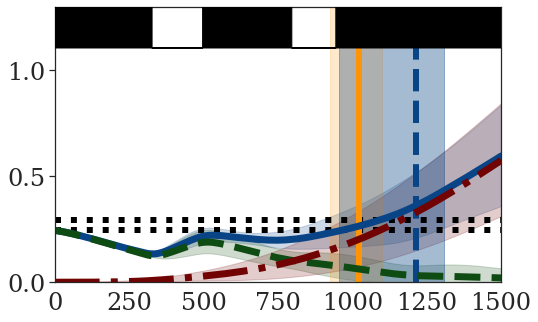

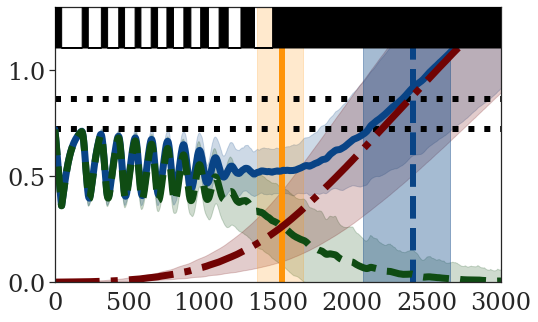

In [55]:
xlimDic = {0:1500, 1:1500, 2:3000}
for tumourId, (initialSize, rFrac, cost, turnover) in enumerate(tumourList):
    tmpList = []
    for i,txName in enumerate(["MTD","AT50"]):
        for replicateId in range(nReplicates):
            currDfName = os.path.join(dataDir,"tumour_%d/"%tumourId,"%s_cellCounts_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,rFrac,initialSize,replicateId))
            tmpDf = pd.read_csv(currDfName)
            tmpDf['NCells'] /= 1e4
            tmpDf['NCells_S'] /= 1e4
            tmpDf['NCells_R'] /= 1e4
            tmpDf['TreatmentBranch'] = txName
            tmpDf['ReplicateId'] = replicateId
            tmpList.append(tmpDf)
        dataDf = pd.concat(tmpList)
        dataDf.rename(columns={"NCells":"V","NCells_S":"S","NCells_R":"R"},inplace=True)
    # Plot
    GenerateATComparisonPlot_CA(dataDf,minTime=150,t_end=xlimDic[tumourId],ylim=1.3,
                                showProgression=True,printTTPB=True,
                                figsize=(8,5),savefigB=True,
                                outName="figures/exampleSim_circleICs_tumour_%d.pdf"%tumourId)

#### Plot images

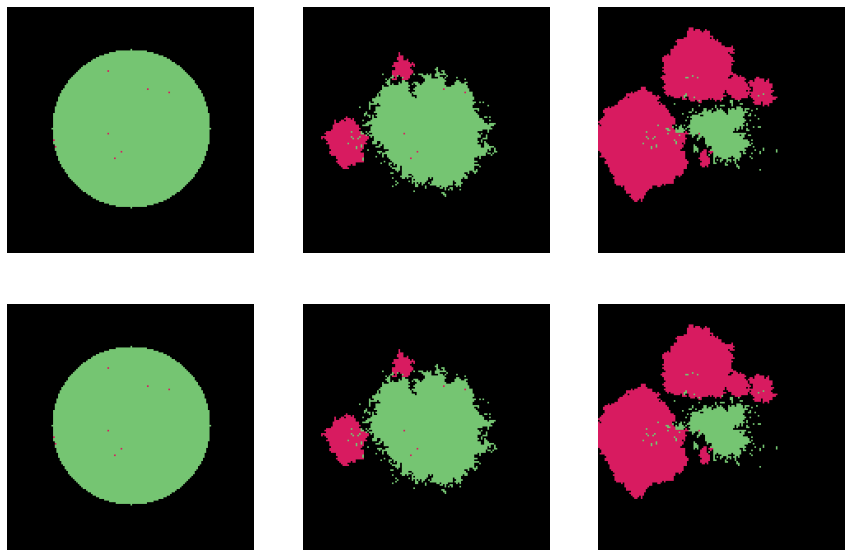

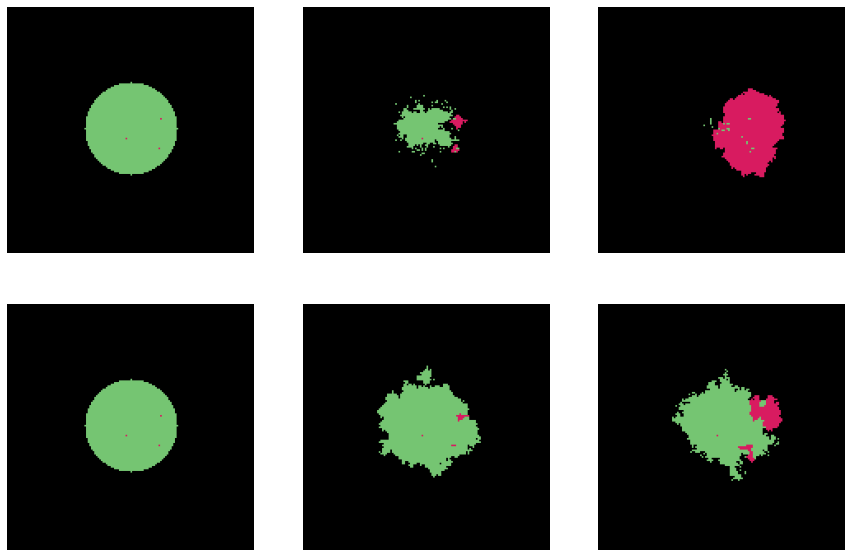

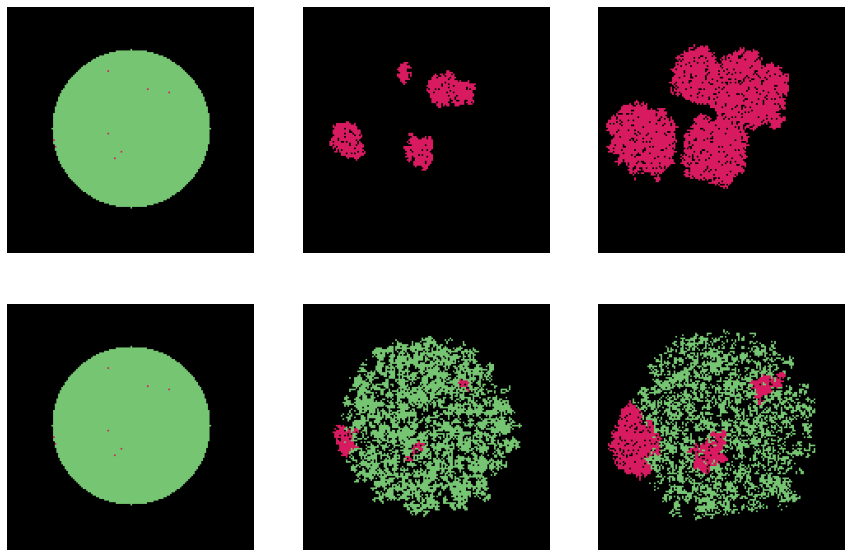

In [56]:
timePointDic = {0:[0,500,1000], 1:[0,500,1000], 2:[0,500,1000]}

for tumourId, (initialSize, rFrac, cost, turnover) in enumerate(tumourList):
    timePointList = timePointDic[tumourId]
    fig,axList = plt.subplots(2,len(timePointList),figsize=(len(timePointList)*5,10))
    for i,timePoint in enumerate(timePointList):
        for j,txName in enumerate(["MTD","AT50"]):
            # Load image
            currImgDir = os.path.join(imgDir,"tumour_%d/"%tumourId,"%s_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d"%(txName,rFrac,initialSize,seedToShowImagesFor))
            currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(timePoint))))
            currImg = cv2.cvtColor(currImg, cv2.COLOR_BGR2RGB)

            currAx = axList[j,i]
            currAx.imshow(currImg)
            currAx.axis('off')
    plt.savefig("figures/exampleSim_circleICs_images_tumour_%d.pdf"%tumourId)

#### Plot competition over time

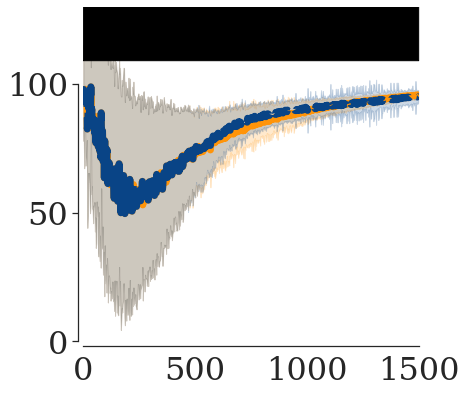

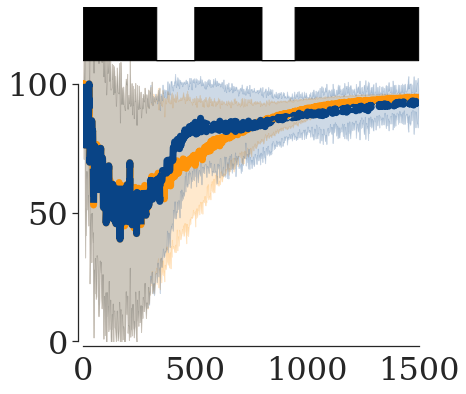

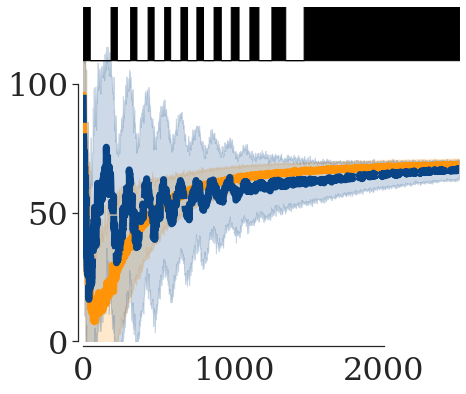

In [57]:
xlimDic = {0:1500, 1:1500, 2:2500}
for tumourId, (initialSize, rFrac, cost, turnover) in enumerate(tumourList):
    fig,ax = plt.subplots(1,1,figsize=(7,6))
    tmpList = []
    for i,txName in enumerate(["MTD","AT50"]):
        for replicateId in range(nReplicates):
            currDfName = os.path.join(dataDir,"tumour_%d/"%tumourId,"%s_cellCounts_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,rFrac,initialSize,replicateId))
            tmpDf = pd.read_csv(currDfName)
            tmpDf['TreatmentBranch'] = txName
            tmpDf['ReplicateId'] = replicateId
            tmpList.append(tmpDf)
    dataDf = pd.concat(tmpList)
    dataDf.rename(columns={"NCells":"V","NCells_S":"S","NCells_R":"R"},inplace=True)
    # Plot
    dataDf = dataDf[dataDf.Time<xlimDic[tumourId]]
    dataDf = dataDf[::2]
    dataDf['PropFailedDivs'] = dataDf.NFailedDivs/dataDf.NAttemptedDivs*100
    PlotCompetitionOverTime(dataDf,decoratey=i>0,xlim=xlimDic[tumourId],ylim=130,y2lim=1/1.2,errStyle='sd',ax=ax)
    plt.tight_layout()
    plt.savefig("figures/competitionPlots_circleICs_tumour_%d.pdf"%tumourId)

## Figure A5: Example simulations comparing CA and ODE - Dependence $n_0$ and $f_R$

In [81]:
# Params for the figure
initialSize = 0.75
rFracList = [0.1, 0.01, 0.001]
turnover = 0
cost = 0
nReplicates = 250
tEnd = 2100 # Used for generating simulations
tEndDic = {0.1:350, 0.01:650, 0.001:1900} # Used for plotting
dataDir = "./data/exampleSims_odeComparison/"

# Params for the ODE solver
paramDic = {"rS":.027, "rR":.027, "cRS":1., "cSR":1.,"dD":1.5, 
            "k":1., "D":0, "theta":1, 'DMax':1.}
dt = 1.
nTimePts = 100
intervalLength = 1

### Collect CA Data

In [27]:
# Collect the data for the time series plots showing the treatment dynamics avaraged across nReplicate simulations
if runCASimulations:
    for rFrac in tqdm(rFracList):
        modelConfigDic = {"initialSize":initialSize,"rFrac":rFrac,"turnover":turnover,"cost":cost,
                          "tEnd":tEnd,"nReplicates":nReplicates,
                          "profilingMode":"false","terminateAtProgression":"false",
                          "outDir":dataDir}
        RunSimulation(modelConfigDic)

100%|██████████| 3/3 [16:29<00:00, 329.81s/it]


### Collect ODE Data

In [28]:
if runCASimulations:
    for rFrac in tqdm(rFracList):
        currOutDir = os.path.join(dataDir,"ODE/turnover%1.2f/cost%1.2f/"%(turnover,cost))
        mkdir(currOutDir)
        # Get the parameters
        initialStateVec,currParamDic = GenerateParameterDic(initialSize=initialSize,rFrac=rFrac,
                                                            cost=cost,turnover=turnover,paramDic=paramDic)

        for txName in ["MTD", "AT50"]:
            # Simulate
            resultsDf = Simulate_AT_FixedThreshold(initialStateVec,modelFun=rdModel_nsKill,
                                                   paramDic=currParamDic,
                                                   atThreshold=1. if txName=="MTD" else 0.5,
                                                   intervalLength=intervalLength,
                                                   t_end=tEnd,
                                                   t_eval=np.arange(0,tEnd+dt,dt))
            currDfName = os.path.join(currOutDir,"%s_cellCounts_rFrac_%.2g_initSize_%.2g_dt_%1.1f_RepId_0.csv" % (txName, rFrac, initialSize, dt))
            resultsDf.to_csv(currDfName)

100%|██████████| 3/3 [00:41<00:00, 13.68s/it]


### Plot

#### ODE

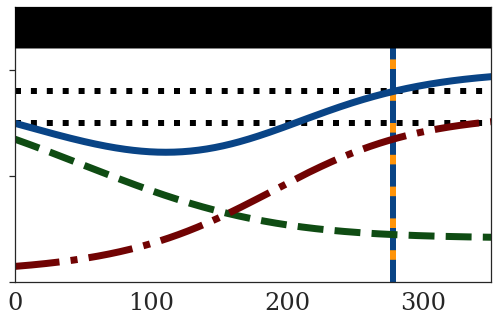

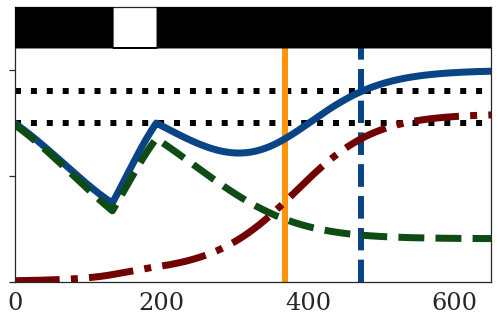

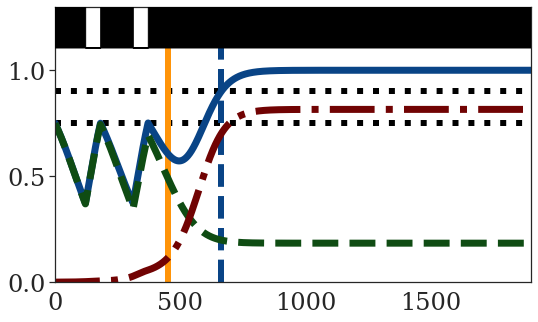

In [18]:
dataDir = "./data/exampleSims_odeComparison/"

for i,rFrac in enumerate(rFracList):
    currOutDir = os.path.join(dataDir,"ODE/turnover%1.2f/cost%1.2f/"%(turnover,cost))
    # Read the data
    tmpList = []
    replicateId = 0
    for txName in ["MTD","AT50"]:
        currDfName = os.path.join(currOutDir,"%s_cellCounts_rFrac_%.2g_initSize_%.2g_dt_%1.1f_RepId_0.csv" % (txName, rFrac, initialSize, dt))
        tmpDf = pd.read_csv(currDfName,index_col=0)
        tmpDf['TreatmentBranch'] = txName
        tmpDf['ReplicateId'] = replicateId
        tmpList.append(tmpDf)
    dataDf = pd.concat(tmpList)
    dataDf.rename(columns={"D":"DrugConcentration"},inplace=True)
    # Plot
    GenerateATComparisonPlot_CA(dataDf,minTime=150,t_end=tEndDic[rFrac],ylim=1.3,
                                showProgression=True,
                                decoratex=True,decoratey=i==2,
                                figsize=(8,5),savefigB=True,
                                outName="figures/odeComparison_ODE_noTurnover_rFrac_%1.2f.pdf"%(rFrac))

#### CA

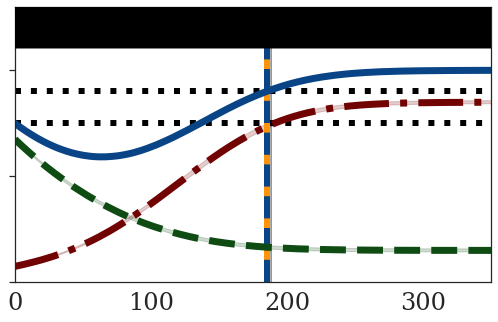

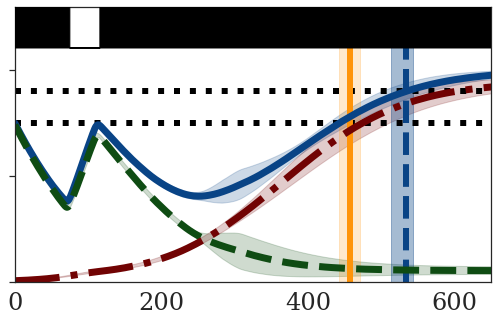

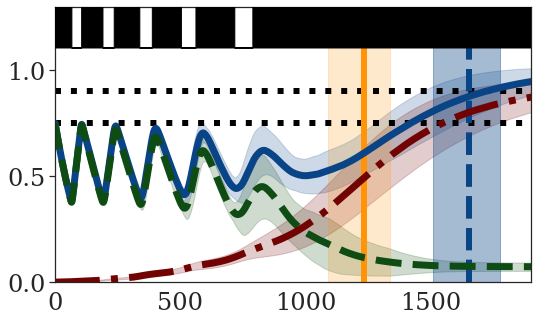

In [19]:
for i,rFrac in enumerate(rFracList):
    # Read the data
    tmpList = []
    for currReplicate in range(nReplicates):
        for txName in ["MTD","AT50"]:
            currDfName = os.path.join(dataDir,"%s_cellCounts_cost_%1.1f_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,cost,rFrac,initialSize,currReplicate))
            tmpDf = pd.read_csv(currDfName)
            tmpDf['NCells'] /= 1e4
            tmpDf['NCells_S'] /= 1e4
            tmpDf['NCells_R'] /= 1e4
            tmpDf['TreatmentBranch'] = txName
            tmpDf['ReplicateId'] = currReplicate
            tmpList.append(tmpDf)
    dataDf = pd.concat(tmpList)
    dataDf.rename(columns={"NCells":"V","NCells_S":"S","NCells_R":"R"},inplace=True)
    # Plot
    GenerateATComparisonPlot_CA(dataDf,minTime=150,t_end=tEndDic[rFrac],ylim=1.3,
                                showProgression=True,
                                decoratex=True,decoratey=i==2,
                                figsize=(8,5),savefigB=True,
                                outName="figures/odeComparison_CA_noTurnover_rFrac_%1.2f.pdf"%(rFrac))

## Figure A6: Comparison to ODE - Dependence $c_R$ and $d_T$

### a) Example Simulations

In [82]:
# Params for the figure
initialSize = 0.5
rFrac = 0.01
turnoverList = [0,0.3]
costList = [0,0.3]
nReplicates = 250
tEnd = 3.65e3
tEndDic = {0:450, 1:700, 2:650, 3:1500} # Used for plotting
dataDir = "./data/exampleSims_odeComparison/"

#### Collect ODE Data

In [30]:
# Params for the ODE solver
paramDic = {"rS":.027, "rR":.027, "cRS":1., "cSR":1.,"dD":1.5, 
            "k":1., "D":0, "theta":1, 'DMax':1.}
dt = 1.
nTimePts = 100
intervalLength = 1

In [31]:
if runCASimulations:
    for cost, turnover in tqdm(list(product(costList,turnoverList))):
        currOutDir = os.path.join(dataDir,"ODE/turnover%1.2f/cost%1.2f/"%(turnover,cost))
        mkdir(currOutDir)
        # Get the parameters
        initialStateVec,currParamDic = GenerateParameterDic(initialSize=initialSize,rFrac=rFrac,
                                                            cost=cost,turnover=turnover,paramDic=paramDic)

        for txName in ["MTD", "AT50"]:
            # Simulate
            resultsDf = Simulate_AT_FixedThreshold(initialStateVec,modelFun=rdModel_nsKill,
                                                   paramDic=currParamDic,
                                                   atThreshold=1. if txName=="MTD" else 0.5,
                                                   intervalLength=intervalLength,
                                                   t_end=tEnd,
                                                   t_eval=np.arange(0,tEnd+dt,dt))
            currDfName = os.path.join(currOutDir,"%s_cellCounts_rFrac_%.2g_initSize_%.2g_dt_%1.1f_RepId_0.csv" % (txName, rFrac, initialSize, dt))
            resultsDf.to_csv(currDfName)

  0%|          | 0/4 [00:00<?, ?it/s]

./data/exampleSims_odeComparison/ODE/turnover0.00/cost0.00/


 25%|██▌       | 1/4 [00:27<01:22, 27.57s/it]

./data/exampleSims_odeComparison/ODE/turnover0.30/cost0.00/


 50%|█████     | 2/4 [00:53<00:53, 26.65s/it]

./data/exampleSims_odeComparison/ODE/turnover0.00/cost0.30/


 75%|███████▌  | 3/4 [01:19<00:26, 26.19s/it]

./data/exampleSims_odeComparison/ODE/turnover0.30/cost0.30/


100%|██████████| 4/4 [01:42<00:00, 25.74s/it]


#### Plot ODE

3it [00:01,  2.21it/s]/Users/Maxi/miniconda3/envs/python3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Maxi/miniconda3/envs/python3.6/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Maxi/miniconda3/envs/python3.6/lib/python3.6/site-packages/numpy/core/numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/Maxi/miniconda3/envs/python3.6/lib/python3.6/site-packages/numpy/core/numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/Maxi/miniconda3/envs/python3.6/lib/python3.6/site-packages/numpy/core/numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/Maxi/miniconda3/envs/p

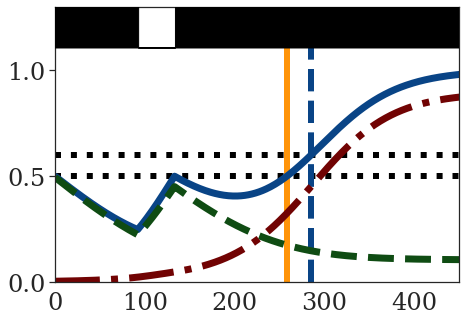

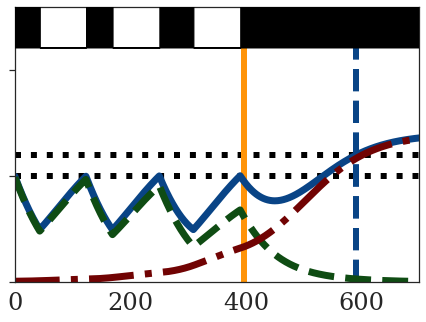

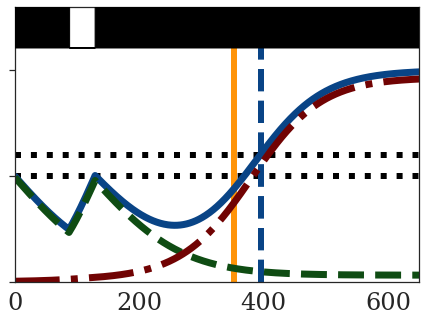

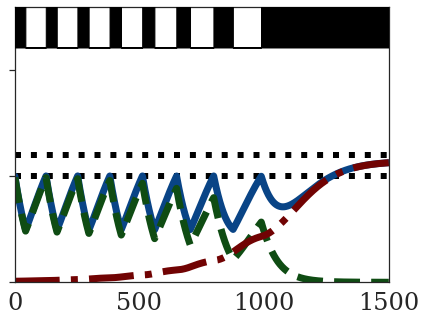

In [32]:
dataDir = "./data/exampleSims_odeComparison/"

for i, (cost, turnover) in tqdm(enumerate(product(costList,turnoverList))):
    currOutDir = os.path.join(dataDir,"ODE/turnover%1.2f/cost%1.2f/"%(turnover,cost))
    # Read the data
    tmpList = []
    replicateId = 0
    for txName in ["MTD","AT50"]:
        currDfName = os.path.join(currOutDir,"%s_cellCounts_rFrac_%.2g_initSize_%.2g_dt_%1.1f_RepId_0.csv" % (txName, rFrac, initialSize, dt))
        tmpDf = pd.read_csv(currDfName,index_col=0)
        tmpDf['TreatmentBranch'] = txName
        tmpDf['ReplicateId'] = replicateId
        tmpList.append(tmpDf)
    dataDf = pd.concat(tmpList)
    dataDf.rename(columns={"D":"DrugConcentration"},inplace=True)
    # Plot
#     print("cost_%1.2f_turnover_%1.2f.pdf"%(cost,turnover))
    GenerateATComparisonPlot_CA(dataDf,minTime=150,t_end=tEndDic[i],ylim=1.3,
                                showProgression=True,
                                decoratex=True,decoratey=i==0,
                                figsize=(7,5),savefigB=True,
                                outName="figures/odeComparison_ODE_cost_%1.2f_turnover_%1.2f.pdf"%(cost,turnover))

#### Plot CA

4it [00:50, 12.53s/it]


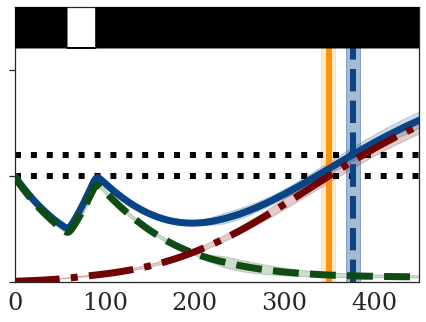

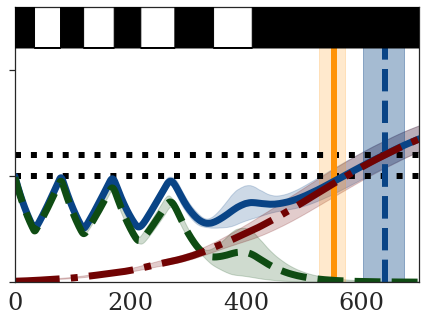

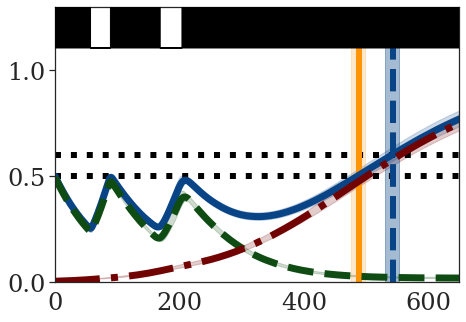

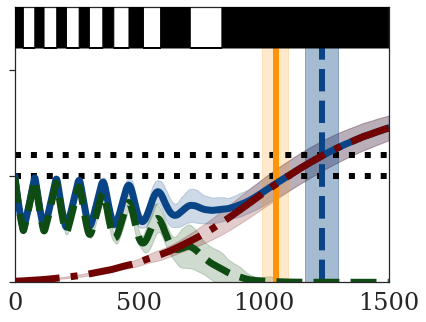

In [21]:
dataDir = "../analysis_paper/data/exampleSims_withCost_withTurnover/data/"

for i, (cost, turnover) in tqdm(enumerate(product(costList,turnoverList))):
    # Read the data
    currOutDir = os.path.join(dataDir,"turnover%1.2f/cost%1.2f"%(turnover,cost))
    tmpList = []
    for currReplicate in range(nReplicates):
        for txName in ["MTD","AT50"]:
            currDfName = os.path.join(currOutDir,"%s_cellCounts_cost_%1.1f_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,cost*100,rFrac,initialSize,currReplicate))
            tmpDf = pd.read_csv(currDfName)
            tmpDf['NCells'] /= 1e4
            tmpDf['NCells_S'] /= 1e4
            tmpDf['NCells_R'] /= 1e4
            tmpDf['TreatmentBranch'] = txName
            tmpDf['ReplicateId'] = currReplicate
            tmpList.append(tmpDf)
    dataDf = pd.concat(tmpList)
    dataDf.rename(columns={"NCells":"V","NCells_S":"S","NCells_R":"R"},inplace=True)
    # Plot
    GenerateATComparisonPlot_CA(dataDf,minTime=150,t_end=tEndDic[i],ylim=1.3,
                                showProgression=True,
                                decoratex=True,decoratey=i==2,
                                figsize=(7,5),savefigB=True,
                                outName="figures/odeComparison_CA_cost_%1.2f_turnover_%1.2f.pdf"%(cost,turnover))

### b) & c) TTP Comparison

In [17]:
# Params for the figure
initialSize = 0.5
rFrac = 0.01
costList = [0,0.1,0.2,0.3]
turnoverList = [0,0.1,0.2,0.3]
tEnd = 3.65e3
nProcesses = 2
dataDir = "./data/exampleSims_odeComparison/ttpComparison_ODE/"

#### Collect ODE Data

In [83]:
def RunODESimulation(jobDic):
    initialSize, rFrac, cost, turnover = (jobDic['initialSize'],jobDic['rFrac'],jobDic['cost'],jobDic['turnover'])
    paramDic, dt, intervalLength, tEnd = (jobDic['paramDic'],jobDic['dt'],jobDic['intervalLength'],jobDic['tEnd'])
    currOutDir = jobDic['outDir']
    mkdir(currOutDir)
    # Get the parameters
    initialStateVec,currParamDic = GenerateParameterDic(initialSize=initialSize,rFrac=rFrac,
                                                        cost=cost,turnover=turnover,paramDic=paramDic)
    # Run Simulations
    txComparisonDf = ProfileTreatmentStrategies(modelFun=rdModel_nsKill,paramDic=currParamDic,
                                                enableProgressBar=False,
                                                atThresholdList=[0.5],intervalLength=intervalLength,
                                                initialSizeList=[initialSize],
                                                rFracList=[rFrac],
                                                tumourSizeWhenProgressed=1.2,cureThreshold=1e-7)
    # Save results
    txComparisonDf['Turnover'] = turnover
    txComparisonDf['Cost'] = cost
    currDfName = os.path.join(currOutDir,"txComparisonDf_rFrac_%.2g_initSize_%.2g.csv" % (rFrac, initialSize))
    txComparisonDf.to_csv(currDfName)

In [19]:
initialSizeList = [initialSize]
rFracList = [rFrac]

if runCASimulations:
    pool = mp.Pool(processes=nProcesses)
    jobList = []
    for initialSize, rFrac, cost, turnover, in product(initialSizeList, rFracList, costList, turnoverList):
        currOutDir = os.path.join(dataDir,"turnover%d/cost%d/"%(turnover*100,cost*100))
        jobList.append({"initialSize":initialSize, "rFrac":rFrac, "turnover":turnover, "cost":cost,
                        "paramDic":paramDic, "dt":dt, "intervalLength":intervalLength, "tEnd":tEnd,
                        "outDir":currOutDir})
    tqdm(pool.imap(RunODESimulation, jobList), total=len(jobList))

  0%|          | 0/16 [00:00<?, ?it/s]

#### Get CA data

Note: To collect these data use the `collectData_costSweep.py` script and modify so that it collects the data for the cost and turnover values stated above. To allow reproducing the figures in the paper, I have uploaded the final data file to the GitHub repository.

In [41]:
txComparisonDf_CA = pd.read_csv("./data/costTurnoverSweep_CA.csv", index_col=0)
txComparisonDf_CA['AbsTimeGained_CA'] = txComparisonDf_CA.TTP_AT50_CA - txComparisonDf_CA.TTP_CT_CA

#### Assemble Data Frame

In [42]:
tmpDicList = []
for initialSize, rFrac, cost, turnover, in product(initialSizeList, rFracList, costList, turnoverList):
    currOutDir = os.path.join(dataDir,"turnover%d/cost%d/"%(turnover*100,cost*100))
    currDfName = os.path.join(currOutDir,"txComparisonDf_rFrac_%.2g_initSize_%.2g.csv" % (rFrac, initialSize))
    tmpDf = pd.read_csv(currDfName)

    # Analyse
    ttp_MTD = tmpDf.TimeToFailure[tmpDf.TreatmentBranch=="MTD"].values[0]
    ttp_AT = tmpDf.TimeToFailure[tmpDf.TreatmentBranch=="0.5"].values[0]
    tmpDicList.append({"Cost":cost,"Turnover":turnover,
                       "TTP_MTD":ttp_MTD,"TTP_AT50":ttp_AT,
                       "AbsTimeGained":ttp_AT-ttp_MTD,
                       "RelTimeGained":(ttp_AT-ttp_MTD)/ttp_MTD*100})
txComparisonDf_ODE = pd.DataFrame(tmpDicList)
txComparisonDf_ODE.to_csv('./data/costTurnoverSweep_ODE.csv')

In [44]:
txComparisonDf = txComparisonDf_CA[["Cost","Turnover","ReplicateId",
                                    "TTP_AT50_CA","RelTimeGained_CA","AbsTimeGained_CA"]].copy()
txComparisonDf['TTP_AT50_ODE'] = np.nan
txComparisonDf['AbsTimeGained_ODE'] = np.nan
txComparisonDf['RelTimeGained_ODE'] = np.nan

for cost,turnover in product(costList,turnoverList):
    ttp_AT50_ODE = txComparisonDf_ODE.loc[(txComparisonDf_ODE.Cost==cost) & 
                                               (txComparisonDf_ODE.Turnover==turnover),'TTP_AT50'].values[0]
    absTimeGained_ODE = txComparisonDf_ODE.loc[(txComparisonDf_ODE.Cost==cost) & 
                                               (txComparisonDf_ODE.Turnover==turnover),'AbsTimeGained'].values[0]
    relTimeGained_ODE = txComparisonDf_ODE.loc[(txComparisonDf_ODE.Cost==cost) & 
                                           (txComparisonDf_ODE.Turnover==turnover),'RelTimeGained'].values[0]
    txComparisonDf.loc[(txComparisonDf.Cost==cost) & 
                       (txComparisonDf.Turnover==turnover),'TTP_AT50_ODE'] = ttp_AT50_ODE
    txComparisonDf.loc[(txComparisonDf.Cost==cost) & 
                       (txComparisonDf.Turnover==turnover),'AbsTimeGained_ODE'] = absTimeGained_ODE
    txComparisonDf.loc[(txComparisonDf.Cost==cost) & 
                   (txComparisonDf.Turnover==turnover),'RelTimeGained_ODE'] = relTimeGained_ODE

#### Plot

In [38]:
def QQPlot(dataDf,x="TTP_AT50_ODE",y="TTP_AT50_CA",groupingVariables=["RFrac","InitialTumourSize"],
           axLimVec=None,palette=None,sizeDic=None,ax=None):
    if ax==None: fig,ax = plt.subplots(1,1,figsize=(7,7))
#     if palette is None: palette = {0.001: sns.xkcd_rgb['coral'], 0.01: sns.xkcd_rgb['scarlet'], 0.1: sns.xkcd_rgb['dark red']}
#     if sizeDic is None: sizeDic = {0.35: 150, 0.5: 350, 0.65: 550}
    # Plot the lines
    sns.lineplot(x=x,y=y,err_style='band',ci='sd',
                 hue=groupingVariables[0], style=groupingVariables[0],
                 markers=True,markersize=1,
                 palette=palette,
                 ax=ax,data=dataDf)
    # Add the markers in different sizes to reflect n0
    summaryDf = dataDf.groupby(groupingVariables).mean()
    summaryDf.reset_index(inplace=True)
    sns.scatterplot(x=x,y=y, style=groupingVariables[0],
                    hue=groupingVariables[0], palette=palette,
                    size=groupingVariables[1],
                    markers=True, sizes=sizeDic,
                    ax=ax,
                    legend=False, data=summaryDf)
    # Set x and y axis to equal scale
    if axLimVec is None:
        xLimVec = ax.get_xlim()
        yLimVec = ax.get_ylim()
        axLimVec = [min(xLimVec[0],yLimVec[0]),max(xLimVec[1],yLimVec[1])]
    ax.set_xlim(axLimVec)
    ax.set_ylim(axLimVec)

    # Plot diagonal line to show where TTP would be equal
    xVec = np.linspace(*axLimVec,100)*0.9
    ax.plot(xVec,xVec,color=sns.xkcd_rgb['blue grey'],lw=3,ls='--')

    # Remove axis labels
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(labelsize=24)
    ax.get_legend().remove()
    sns.despine(ax=ax,offset=10, trim=False)

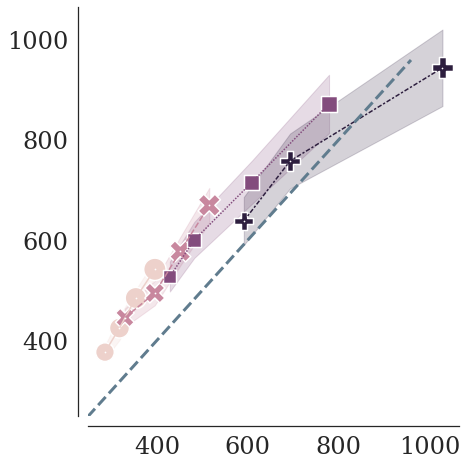

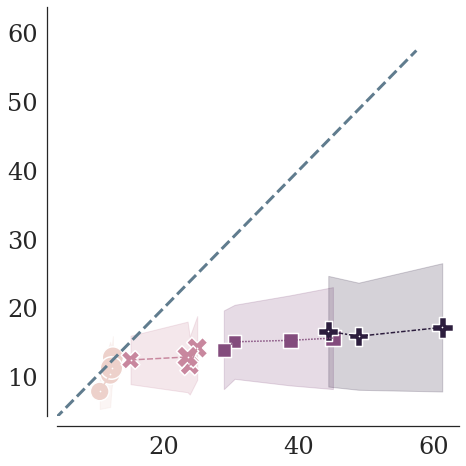

In [39]:
for i,feature in enumerate(["TTP_AT50","RelTimeGained"]):#"AbsTimeGained",
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    QQPlot(txComparisonDf,x="%s_ODE"%feature,y="%s_CA"%feature,
           groupingVariables=["Turnover","Cost"],
           sizeDic = {0.:350, 0.1:400, 0.2:450, 0.3:500},
           ax=ax)
    plt.tight_layout()
    plt.savefig("./figures/odeComparison_summary_noTurnover_%s.pdf"%feature)

### d) Explanation via effective carrying capacity - single population simulations

In [46]:
# Params for the figure
initialSize = 0.5
rFrac = 0.01
turnoverList = [0, 0.3]
costList = [0, 0.3]
nReplicates = 250
tEnd = 3.65e3
seedToShowImagesFor = 0
dataDir = "./data/exampleSims_singlePopulation/data/"

#### Collect data

In [47]:
# Collect the data for the time series plots showing the treatment dynamics avaraged across nReplicate simulations
if runCASimulations:
    for cost,turnover in tqdm(product(costList,turnoverList)):
        currOutDir = os.path.join(dataDir,"turnover%1.2f/cost%1.2f/"%(turnover,cost))
        modelConfigDic = {"initialSize":rFrac*initialSize,"rFrac":1.,"turnover":turnover,"cost":cost,
                          "tEnd":tEnd,"nReplicates":nReplicates,"atThreshold":0.,
                          "compareToMTD":False,
                          "profilingMode":"false","terminateAtProgression":"false",
                          "outDir":currOutDir}
        RunSimulation(modelConfigDic,jarFileName='./onLatticeModel.jar')

4it [00:21,  5.45s/it]


#### Plot

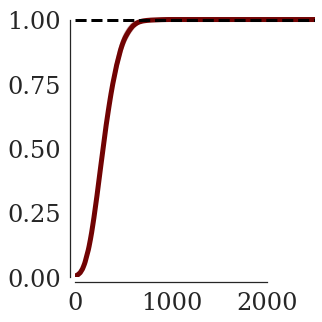

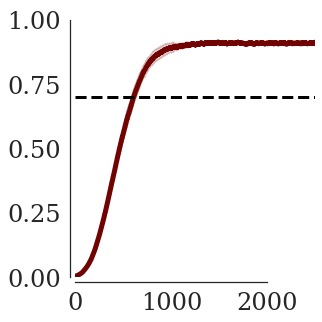

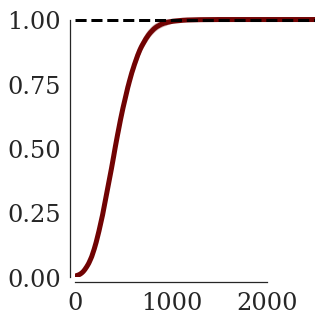

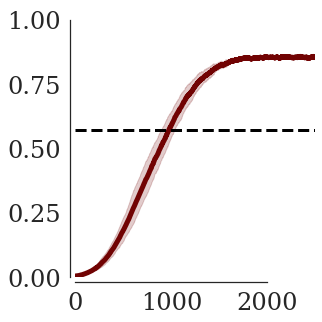

In [48]:
steadyState_Logistic = lambda r,d,K: (1-d/(r+1e-15))*K

for i,(cost,turnover) in enumerate(product(costList,turnoverList)):
    currOutDir = os.path.join(dataDir,"turnover%1.2f/cost%1.2f/"%(turnover,cost))
    # Read the data
    txName = "AT0"
    tmpList = []
    for replicateId in range(nReplicates):
        currDfName = os.path.join(currOutDir,"%s_cellCounts_cost_%1.1f_rFrac_1.0_initSize_0.005_dt_1.0_RepId_%d.csv"%(txName,cost*100,replicateId))
        tmpDf = pd.read_csv(currDfName)
        tmpDf = tmpDf[['Time','NCells_R']]
        tmpDf['NCells_R'] /= 1e4
        tmpDf['ReplicateId'] = replicateId
        tmpList.append(tmpDf)
    dataDf = pd.concat(tmpList)
    # Plot
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    sns.lineplot(x="Time",y="NCells_R",ci='sd',
                 lw=5,color="#710303",
                 ax=ax,data=dataDf)
    ax.plot(np.linspace(0,dataDf.Time.max(),100),np.ones((100,))*steadyState_Logistic(1-cost,turnover,1),
            lw=3,linestyle='--',color='black')

    # Remove axis labels
    ax.set_xlim(0,2500)
    ax.set_ylim(0,1.05)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(labelsize=24)
    sns.despine(ax=ax,offset=5, trim=True)
    plt.tight_layout()
    plt.savefig("./figures/odeComparison_singlePop_cost_%1.2f_turnover_%1.2f.pdf"%(cost,turnover))

### e) Comparing the effective carrying capacity

Note: the data was collected using the `collectData_effectiveKData.py` script.

In [53]:
effectiveKDf = pd.read_csv("./data/effectiveKData.csv",index_col=0)
effectiveKDf['Cost'] *= 100
effectiveKDf['Turnover'] *= 100
effectiveKDf['SteadyStateSize'] /= 1e4

In [54]:
steadyState_Logistic = lambda r,d,K: (1-d/(r+1e-15))*K

tmpDfList = []
xVec = np.linspace(0,50,100)
for turnover in effectiveKDf.Turnover.unique():
    tmpDf = pd.DataFrame(data={"Cost":xVec,
                               "SteadyStateSize":steadyState_Logistic(100-xVec,turnover,1)})
    tmpDf['Turnover'] = turnover
    tmpDf['RFrac'] = 1.    
    tmpDfList.append(tmpDf)
effectiveKDf_ODE = pd.concat(tmpDfList)

In [55]:
steadyState_Kimmel = lambda r,d,K: np.power((1-d/(r+1e-15)),1/4)*K

tmpDfList = []
xVec = np.linspace(0,50,100)
for turnover in effectiveKDf.Turnover.unique():
    tmpDf = pd.DataFrame(data={"Cost":xVec,
                               "SteadyStateSize":steadyState_Kimmel(100-xVec,turnover,1)})
    tmpDf['Turnover'] = turnover
    tmpDf['RFrac'] = 1.
    tmpDfList.append(tmpDf)
effectiveKDf_Kimmel = pd.concat(tmpDfList)

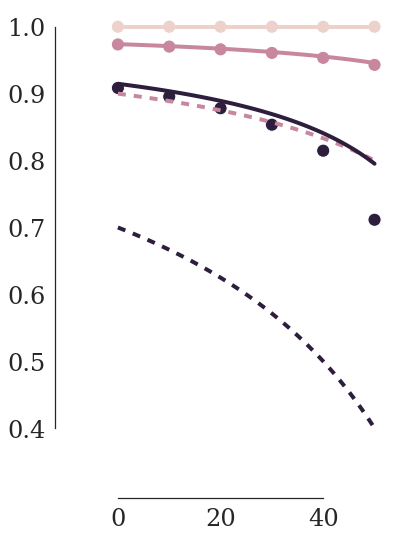

In [56]:
fig,ax = plt.subplots(1,1,figsize=(6,8))

summaryDf = effectiveKDf.groupby(["Cost","Turnover"]).mean()
summaryDf.reset_index(inplace=True)
sns.scatterplot(x="Cost",y="SteadyStateSize",s=175,
                hue='Turnover',
                ax=ax, legend=False, data=summaryDf)

sns.lineplot(x="Cost",y="SteadyStateSize",
             hue="Turnover",style='RFrac',
             linewidth=4, dashes={1:(2, 2)},
             ax=ax,data=effectiveKDf_ODE)

sns.lineplot(x="Cost",y="SteadyStateSize",
             hue="Turnover",
             linewidth=4, 
             ax=ax,data=effectiveKDf_Kimmel)

# Remove axis labels
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=24)
ax.get_legend().remove()
sns.despine(ax=ax,offset=50, trim=True)
plt.tight_layout()
plt.savefig("./figures/odeComparison_effectiveK.pdf")

## Figure A7: Quantitative investigation into worse AT outcomes

### a) Role of the domain size

Note: data collected using `collectData_domainSizeComparison.py`

In [69]:
varyDomainSizeDataDf = pd.read_csv("./data/varyDomainSize.csv",index_col=0)
varyDomainSizeDataDf['Cost'] *= 100

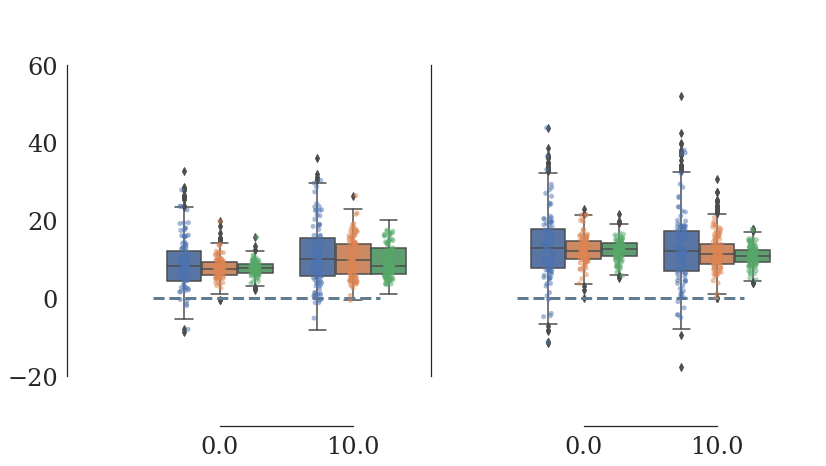

In [77]:
rFrac = 0.01
initialSize = 0.5
currDataDf = varyDomainSizeDataDf[(varyDomainSizeDataDf.InitialTumourSize==initialSize) &
                                  (varyDomainSizeDataDf.RFrac==rFrac)]

fig,axList = plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,7))
for i,turnover in enumerate(varyDomainSizeDataDf.Turnover.unique()):
    currDataDf = varyDomainSizeDataDf[(varyDomainSizeDataDf.InitialTumourSize==initialSize) &
                                      (varyDomainSizeDataDf.RFrac==rFrac) & 
                                      (varyDomainSizeDataDf.Turnover==turnover)]
    ax = axList[i]
    sns.stripplot(x="Cost",y="RelTimeGained_CA",alpha=0.5,dodge=True,
                 hue="DomainSize", 
                  ax=ax,data=currDataDf[::10])
    sns.boxplot(x="Cost",y="RelTimeGained_CA",dodge=True,
                 hue="DomainSize",
                 ax=ax,data=currDataDf)
    ax.plot(np.linspace(-0.5,.8*ax.get_xlim()[1],100),
            np.repeat(0,100),color=sns.xkcd_rgb['blue grey'],lw=3,ls='--')
    ax.set_ylim(-20,75)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(labelsize=24)
    ax.get_legend().remove()
    sns.despine(ax=ax,offset=50, trim=True)
plt.tight_layout()
plt.savefig("./figures/varyDomainSize.pdf")

### b) Quantiative analysis of nest shape

To collect data on nest convexity, run `collectData_convexityAnalysis.py`

In [43]:
cost = 0
turnover = 0
rFrac = 0.001
initialSize = 0.25
timePoint = 250

In [44]:
txComparisonDf = pd.read_csv("./data/n0Sweep.csv",index_col=0)
txComparisonDf['AbsTimeGained_CA'] = txComparisonDf.TTP_AT50_CA - txComparisonDf.TTP_CT_CA
nNestDataDf = pd.read_csv("./data/convexityAnalysis.csv",index_col=0)

txComparisonDf_noTurnover = txComparisonDf[(txComparisonDf.Cost==cost) & (txComparisonDf.Turnover==turnover)]

tmpDicList = []
for replicateId in nNestDataDf.ReplicateId.unique():
    currDataDf = nNestDataDf[(nNestDataDf.ReplicateId==replicateId) &
                                   (nNestDataDf.Time==timePoint)]
    deltaNests = currDataDf.NNests[currDataDf.TreatmentBranch=="AT50"].values[0] - \
                 currDataDf.NNests[currDataDf.TreatmentBranch=="MTD"].values[0]
    deltaConvexity = currDataDf.MeanConvexity[currDataDf.TreatmentBranch=="AT50"].values[0] - \
                 currDataDf.MeanConvexity[currDataDf.TreatmentBranch=="MTD"].values[0]
    relTimeGained = txComparisonDf_noTurnover.RelTimeGained_CA[(txComparisonDf_noTurnover.RFrac==rFrac) &
                                                                (txComparisonDf_noTurnover.InitialTumourSize==initialSize) &
                                                                (txComparisonDf_noTurnover.ReplicateId==replicateId)].values[0]
    absTimeGained = txComparisonDf_noTurnover.AbsTimeGained_CA[(txComparisonDf_noTurnover.RFrac==rFrac) &
                                                                (txComparisonDf_noTurnover.InitialTumourSize==initialSize) &
                                                                (txComparisonDf_noTurnover.ReplicateId==replicateId)].values[0]
    tmpDicList.append({"RFrac": rFrac, "InitialTumourSize": initialSize, "Cost": cost,
                       "Turnover": turnover, "ReplicateId": replicateId,
                       "Time": timePoint, "DeltaNests": deltaNests, "DeltaConvexity":deltaConvexity,
                       "RelTimeGained":relTimeGained,"AbsTimeGained":absTimeGained})
nestComparisonDf = pd.DataFrame(tmpDicList)

0.40680372240674467 3.8481232220023983e-41
44.3600247925844 0.16548926856398363


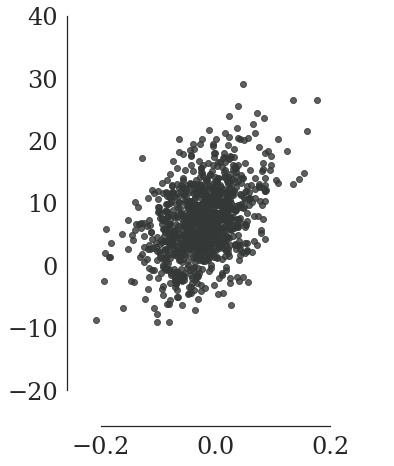

In [46]:
initialSize = 0.25
currDataDf = nestComparisonDf[nestComparisonDf.InitialTumourSize==initialSize]
fig, axList = plt.subplots(1,1,figsize=(6,7))
currAx = axList
sns.regplot(x="DeltaConvexity",y="RelTimeGained",
            color=sns.xkcd_rgb["charcoal"],
            fit_reg=False, line_kws={'color':'orange','linewidth':5},
            ax=currAx,data=currDataDf)

dataToAnalyseDf = currDataDf[np.isnan(currDataDf.RelTimeGained)==False]
r,p = scipy.stats.pearsonr(dataToAnalyseDf.DeltaConvexity,dataToAnalyseDf.RelTimeGained)
print(r, p)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=dataToAnalyseDf.DeltaConvexity,
                                                                 y=dataToAnalyseDf.RelTimeGained)
print(slope, r_value**2)
currAx.set_xlim(-0.25,0.3)
currAx.set_ylim(-25,40)
currAx.set_xlabel("")
currAx.set_ylabel("")
currAx.tick_params(labelsize=24)
sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.savefig("figures/atFailure_convexity_n0_%1.2f.pdf"%initialSize)

## Figure A8: Overview of all patient fits when allowing all 4 parameters to vary

This figure is created during the fitting process when you run `run_dataFitting_all.py`. To create plots of the two patients we excluded because of what looks like erroneous data reporting run the code below:

No handles with labels found to put in legend.
No handles with labels found to put in legend.


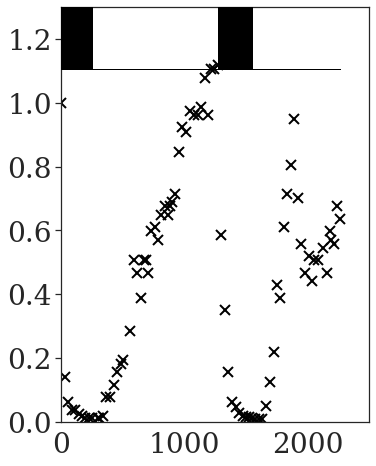

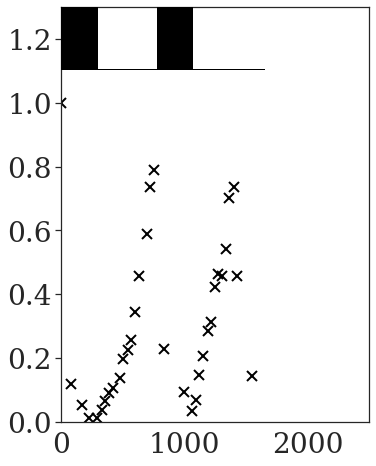

In [32]:
dataDir = "./data/clinicalData/Bruchovsky_et_al/"
patientsToPlotList = [2,104]
for patientId in patientsToPlotList: 
    PlotData(dataDf=LoadPatientData(patientId,dataDir=dataDir),
             xlim=2.5e3,figsize=(6,7),outName="./figures/p%d.pdf"%patientId)

## Figure A9: Comparing fitting of just initial conditions (n0,fR) vs kinetics (cost,turnover)

In [65]:
dataDir = "./data/clinicalData/Bruchovsky_et_al/"
fitDir = "./data/fits/"
patientList_all = [int(re.findall(r'\d+',x)[0]) for x in os.listdir(dataDir)]
nFits = 10
solver_kws = {'nReplicates':250}
initialSeedingType = "random"
patientsToExcludeDic = {"fits_all": [32, 46, 64, 83, 92] + [2,3,6,11,50,52,84,95,101,104,105], # patients with mets + patients with poor fits
                        "fits_costTurnover": [32, 46, 64, 83, 92] + [2,3,6,11,13,50,52,84,95,101,104]}
# Format plots
sns.set(style="white",
        font_scale=1.5,
        rc={'figure.figsize':(12,6)})

### Compare fits

In [66]:
modelList = ['fits_all','fits_n0fR','fits_costTurnover']
tmpDfList = []
for model in modelList:
    currFitDir = os.path.join(fitDir,model)
    tmpDf = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf.csv"),index_col=0)
    tmpDf['Model'] = model
    tmpDfList.append(tmpDf)
modelComparisonDf = pd.concat(tmpDfList)

### Plot heatmaps

In [67]:
# Turn into wide format
fitSummaryDf_all_wide = modelComparisonDf.pivot_table(index='PatientId',columns="Model",values=["AIC","BIC","RSquared","Progression"])
fitSummaryDf_all_wide = fitSummaryDf_all_wide.sort_index(axis=1, level=1)
fitSummaryDf_all_wide.columns = [f'{x}_{y}' for x,y in fitSummaryDf_all_wide.columns]
fitSummaryDf_all_wide['Progression'] = fitSummaryDf_all_wide.RSquared_fits_all
# fitSummaryDf_all_wide.drop(columns=["RSquared_random","RSquared_random_vary_n0fR","RSquared_random_vary_costTurnover"])
fitSummaryDf_all_wide.reset_index(inplace=True)

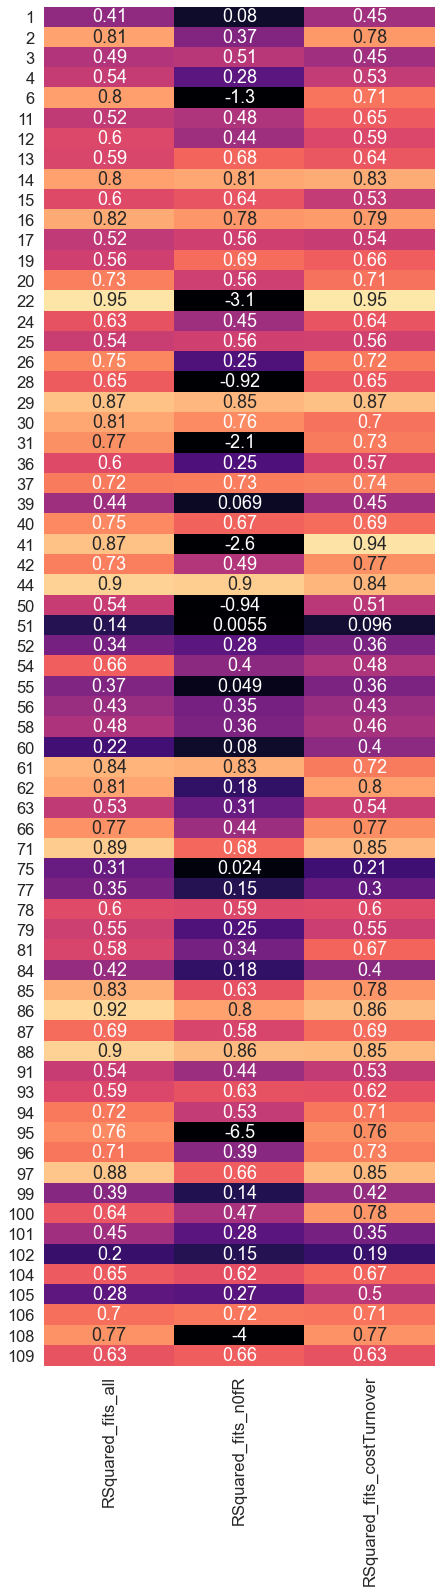

In [73]:
metric = 'RSquared'
colList = ['PatientId'] + ["_".join([metric,x]) for x in modelList]
currDataDf = fitSummaryDf_all_wide[colList].copy()#.sort_values(by="RSquared_random_vary_n0fR")
# for x in modelList[::-1]: currDataDf["_".join([metric,x])] -= currDataDf["_".join([metric,modelList[0]])]
plt.figure(figsize=(7,25))
sns.heatmap(data=currDataDf[colList[1:]],cbar=False,
            annot=True,yticklabels=currDataDf.PatientId.unique(),
            cmap="magma",vmin=0,vmax=1)
plt.savefig("./figures/fitComparison_r2.pdf")

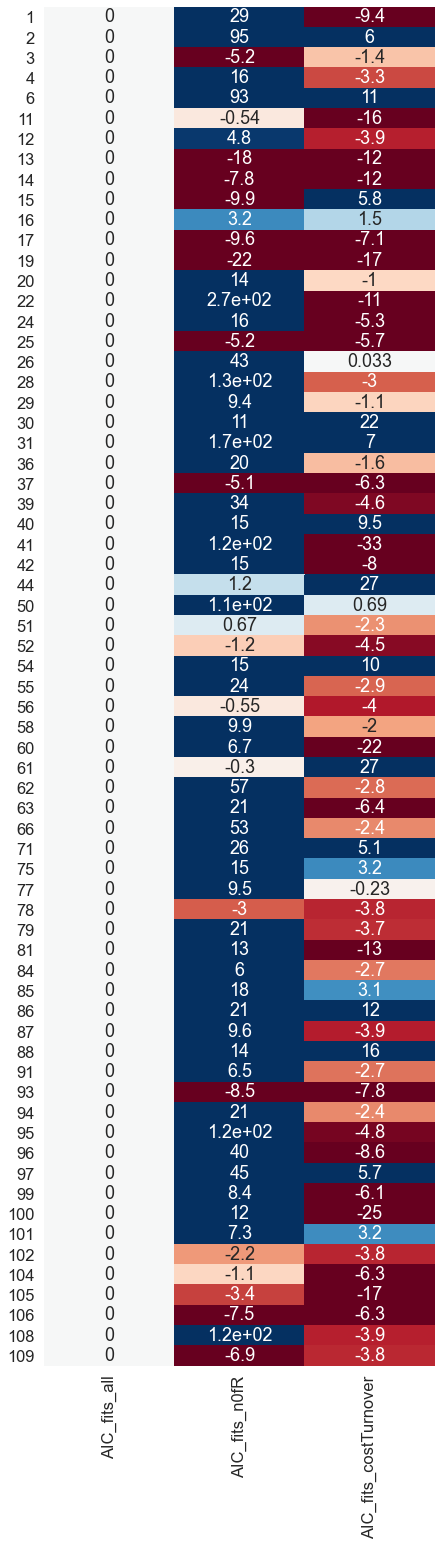

In [74]:
metric = 'AIC'
colList = ['PatientId'] + ["_".join([metric,x]) for x in modelList]
currDataDf = fitSummaryDf_all_wide[colList].copy()#.sort_values(by="RSquared_random_vary_n0fR")
for x in modelList[::-1]: currDataDf["_".join([metric,x])] -= currDataDf["_".join([metric,modelList[0]])]
plt.figure(figsize=(7,25))
sns.heatmap(data=currDataDf[colList[1:]],cbar=False,
            annot=True,yticklabels=currDataDf.PatientId.unique(),
            cmap="RdBu",vmin=-5,vmax=5)
plt.savefig("./figures/fitComparison_aic.pdf")

### Statistics

In [21]:
print(len(modelComparisonDf.RSquared[modelComparisonDf.Model=="fits_all"].values))
scipy.stats.ttest_rel(a=modelComparisonDf.RSquared[modelComparisonDf.Model=="fits_all"].values,
                      b=modelComparisonDf.RSquared[modelComparisonDf.Model=="fits_costTurnover"].values)
# statsmodels.stats.weightstats.DescrStatsW.tconfint_mean(modelComparisonDf.RSquared[modelComparisonDf.Model=="fits_all"].values - modelComparisonDf.RSquared[modelComparisonDf.Model=="fits_costTurnover"].values)


67


Ttest_relResult(statistic=0.11160742204824145, pvalue=0.9114734178031328)

In [18]:
import statsmodels.stats.weightstats as sms

cm = sms.CompareMeans(sms.DescrStatsW(modelComparisonDf.RSquared[modelComparisonDf.Model=="fits_all"].values), 
                      sms.DescrStatsW(modelComparisonDf.RSquared[modelComparisonDf.Model=="fits_costTurnover"].values))
print(cm.tconfint_diff(usevar='unequal'))

(-0.06061384523233421, 0.0683191952220093)


In [19]:
scipy.stats.ttest_rel(a=modelComparisonDf.RSquared[modelComparisonDf.Model=="fits_all"].values,
                      b=modelComparisonDf.RSquared[modelComparisonDf.Model=="fits_n0fR"].values)

Ttest_relResult(statistic=3.657381856865688, pvalue=0.0005070408931122703)

In [20]:
cm = sms.CompareMeans(sms.DescrStatsW(modelComparisonDf.RSquared[modelComparisonDf.Model=="fits_all"].values), 
                      sms.DescrStatsW(modelComparisonDf.RSquared[modelComparisonDf.Model=="fits_n0fR"].values))
print(cm.tconfint_diff(usevar='unequal'))

(0.23974264377764515, 0.8407398085356639)


## Figure A10: Overview of all fits when fitting only cost and turnover

This figure is created during the fitting process when you run `run_dataFitting_costTurnover.py`.

## Figure A11: Fitting using the circular ICs

In [84]:
dataDir = "./data/clinicalData/Bruchovsky_et_al/"
fitDir = "./data/fits/fits_circle/"
patientList = [12,36,75,105,16,88,19,109,22,31,41] # 6,50,52
nFits = 10
solver_kws_circleICs = {'nReplicates':250, "initialSeedingType":"circle", "xDim":150, "yDim":150}

Fitting is done with `run_dataFitting_circleICs.py`.

#### a) Plot Cost-Turnover landscape

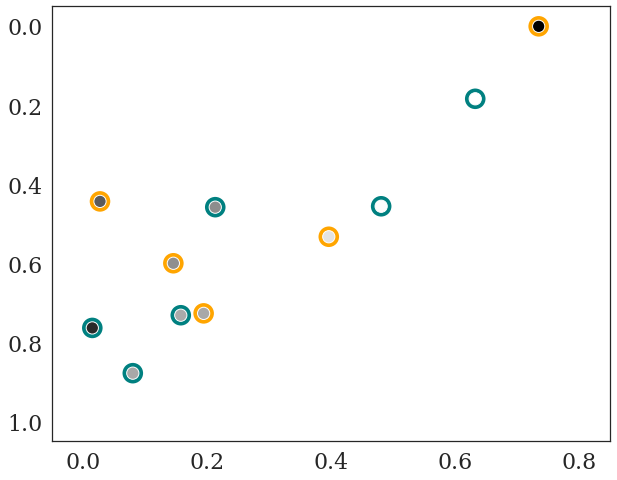

In [85]:
fitSummaryDf = pd.read_csv(os.path.join(fitDir,"fitSummaryDf.csv"),index_col=0)
fitSummaryDf['CyclingFreq'] = fitSummaryDf.NCycles/fitSummaryDf.TimeInTrial*365

fig,ax = plt.subplots(1,1,figsize=(10,8))
dataToAnalyse = fitSummaryDf[np.isin(fitSummaryDf.PatientId,patientList)==True].copy()
sns.scatterplot(x="turnover",y="cost",hue="Progression",s=500, #style="Progression",
                palette={0:"teal",1:"orange"},data=dataToAnalyse,ax=ax)
sns.scatterplot(x="turnover",y="cost",hue="CyclingFreq",s=150, #style="Progression",
                palette='Greys',data=dataToAnalyse,ax=ax)

ax.set_xlim(-0.05,0.85)
ax.set_ylim(-0.05,1.05)
ax.set_xlabel("")
ax.set_ylabel("")
# ax.axis('off')
ax.legend().remove()
ax.invert_yaxis()
plt.savefig("./figures/paramSpacePlot_circleICs.pdf")

In [86]:
scipy.stats.pearsonr(x=fitSummaryDf["turnover"],y=fitSummaryDf['cost'])

(-0.8676493403827945, 5.799340200932848e-05)

#### b) Example plots of individual patients

In [87]:
patientsToPlotList = [75,88,41]
seedToShowImagesFor = 1

##### Time-series plots

P75;R2=0.24
P88;R2=0.85
P41;R2=0.90


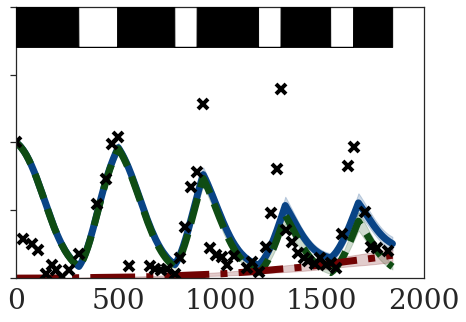

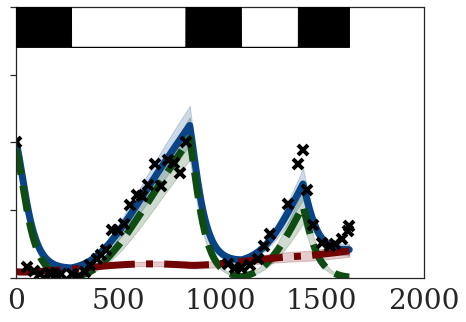

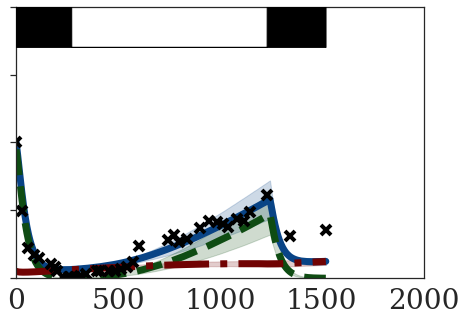

In [88]:
fitSummaryDf = pd.read_csv(os.path.join(fitDir,"fitSummaryDf.csv"),index_col=0)
for patientId in patientsToPlotList:
    fit = GetBestFit(patientId=patientId,summaryDf=fitSummaryDf,fitDir=fitDir)
    PlotFits([fit],dataDf=LoadPatientData(patientId,dataDir=dataDir),
             solver_kws=solver_kws_circleICs, decorateY=False,#patientId==36,
             xlim=2e3,ylim=2.,figsize=(7,5),axisLabels=False,
             outName="./figures/exampleFit_circleICs_p%d.pdf"%(patientId))
    print("P%d;R2=%1.2f"%(patientId,fit.rSq))  

##### Generate the associated images

In [48]:
seedDic = {75:1, 88:1, 41:1}
fitSummaryDf = pd.read_csv(os.path.join(fitDir,"fitSummaryDf.csv"),index_col=0)
imageRecording_kws = {**solver_kws_circleICs, "profilingMode":"false","terminateAtProgression":"true",
                      "imageFreq":10}
imageRecording_kws['nReplicates'] = 1

# To clean up
# for patientId in tqdm(patientList):
#     outDir = os.path.join(currFitDir,"patient%d"%patientId,"images/")
#     shutil.rmtree(outDir)
    
for patientId in tqdm(patientsToPlotList):
    outDir = os.path.join(fitDir,"patient%d"%patientId,"images/data/")
    imgDir = os.path.join(fitDir,"patient%d"%patientId,"images/images/")
    imageRecording_kws['seed'] = seedDic[patientId]
    imageRecording_kws["imageOutDir"] = imgDir
    imageRecording_kws["outDir"] = outDir  
    fit = GetBestFit(patientId=patientId,summaryDf=fitSummaryDf,fitDir=fitDir)
    SimulateFit(fit, dataDf=LoadPatientData(patientId,dataDir=dataDir), trim=False, saveFiles=True, 
                solver_kws=imageRecording_kws)

100%|██████████| 3/3 [00:09<00:00,  3.22s/it]


##### Check that chosen seeds are representative of the mean behaviour

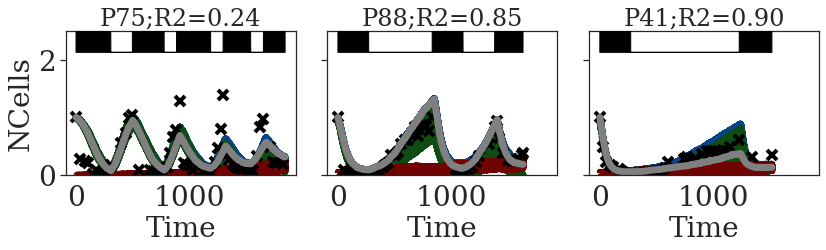

In [50]:
fig, axList = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
for i,patientId in enumerate(patientsToPlotList):
    fit = GetBestFit(patientId=patientId,summaryDf=fitSummaryDf,fitDir=fitDir)
    PlotFits(fits=[fit.fitId], dataDf=LoadPatientData(patientId,dataDir=dataDir), 
             fitDir=fitDir, aggregateData=False,
             solver_kws=solver_kws_circleICs,
             ylim=2.5, titleStr="P%d;R2=%1.2f" % (patientId, fit.rSq), ax=axList.flatten()[i])
    seedToShowImagesFor = seedDic[patientId]
    currDfName = os.path.join(fitDir,"patient%d"%patientId,"images/data/results_RepId_%d.csv"%seedToShowImagesFor)
    tmpDf = pd.read_csv(currDfName)
    tmpDf['NCells'] /= tmpDf['NCells'].iloc[0]
    sns.lineplot(x="Time",y="NCells",lw=7,color="grey",data=tmpDf,ax=axList.flatten()[i])


##### Plot images

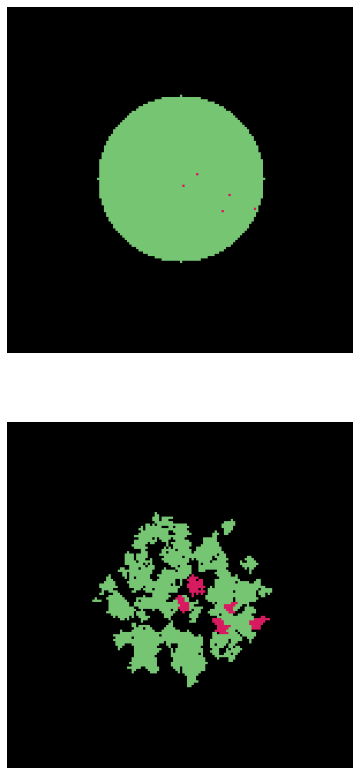

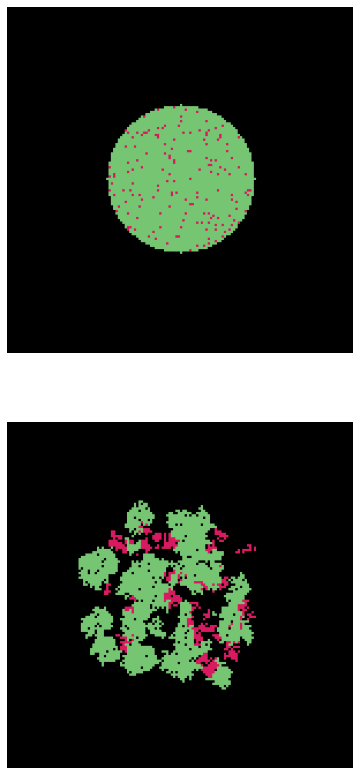

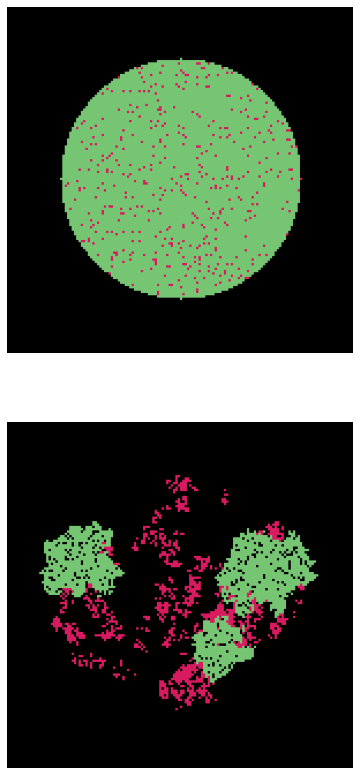

In [51]:
timePointDic = {75:[0,900], 88:[0,1400], 41:[0,1200]}

for patientId in patientsToPlotList:
    timePointList = timePointDic[patientId]
    fig,axList = plt.subplots(len(timePointList),1,figsize=(10,7*len(timePointList)))
    for i,timePoint in enumerate(timePointList):
        # Load image
        seedToShowImagesFor = seedDic[patientId]
        currImgDir = os.path.join(fitDir,"patient%d"%patientId,"images/images/results_RepId_%d"%seedToShowImagesFor)
        currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(timePoint))))
        currImg = cv2.cvtColor(currImg, cv2.COLOR_BGR2RGB)

        currAx = axList[i]
        currAx.imshow(currImg)
        currAx.axis('off')
    plt.savefig("figures/exampleFits_circleICs_images_p%d.pdf"%patientId)